In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
import seaborn as sns
from datetime import date
import sklearn
from sklearn.preprocessing import LabelEncoder
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore') #action='once')


In [2]:
df = pd.read_table('./processed/feature_engineering.csv', sep=',', index_col = 0)
df.head()

,institution,MDN,NotitieID,Typenotitie,Notitiedatum,annotated,ADM_lvl,ATT_lvl,BER_lvl,ENR_lvl,...,avg_domains,rolling_mean3,rolling_mean7,rolling_sum3,rolling_sum7,rolling_min3,rolling_min7,rolling_max3,rolling_max7,expanding_mean
67031,amc,138098,457333386,Zorgplan/VPK rapportage,2020-10-14,False,3.034180,NaN,NaN,1.566406,...,2.933268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77391,amc,138098,456811920,Voortgangsverslag,2020-10-14,False,3.034180,NaN,NaN,1.410156,...,2.383789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.034180
66123,amc,138098,457532765,Voortgangsverslag,2020-10-15,False,2.912109,NaN,NaN,1.762695,...,2.337402,2.993490,NaN,8.980469,NaN,2.912109,NaN,3.034180,NaN,2.993490
77392,amc,138098,457533093,Zorgplan/VPK rapportage,2020-10-15,False,3.478516,NaN,NaN,NaN,...,3.683594,3.141602,NaN,9.424805,NaN,2.912109,NaN,3.478516,NaN,3.114746
79526,amc,138098,457617575,Zorgplan/VPK rapportage,2020-10-15,False,3.478516,NaN,NaN,NaN,...,3.704102,3.289714,NaN,9.869141,NaN,2.912109,NaN,3.478516,NaN,3.187500


## Modelling

### Trying to predict fro ADM_lvl variable

In [3]:
df = df.drop(['institution', 'Typenotitie', 'Notitiedatum', 'ATT_lvl', 'BER_lvl', 'ENR_lvl', 'ETN_lvl', 'FAC_lvl', 'INS_lvl', 'MBW_lvl', 'STM_lvl'], axis=1)
col = df.pop('ADM_lvl')
df.insert(0, col.name, col)
df = df.dropna()

In [4]:
# discretize variables by rounding continuous var into integers
labelenc = LabelEncoder()
df['ADM_lvl'] = df['ADM_lvl'].round(0)
df.iloc[:,0] = labelenc.fit_transform(df.iloc[:,0].values)

In [5]:
df.dtypes

ADM_lvl             int64
MDN                 int64
NotitieID           int64
annotated            bool
year                int64
month               int64
day                 int64
Days_count          int64
Dif                 int64
delta_7             int64
delta_30            int64
delta_60            int64
lag1_ADM            int64
lag2_ADM            int64
lag3_ADM            int64
avg_domains       float64
rolling_mean3     float64
rolling_mean7     float64
rolling_sum3      float64
rolling_sum7      float64
rolling_min3      float64
rolling_min7      float64
rolling_max3      float64
rolling_max7      float64
expanding_mean    float64
dtype: object

In [6]:
#80% of patients in train and 20% of patients in test.

train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 0).split(df, groups=df['MDN']))
train = df.iloc[train_inds]
test = df.iloc[test_inds]

In [7]:
#Now split the data into X and Y
X_train = train.iloc[:, 1:].values
Y_train = train.iloc[:, 0].values

X_test = test.iloc[:, 1:].values
Y_test = test.iloc[:, 0].values

In [8]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(13904, 24)
(13904,)
(3695, 24)
(3695,)


In [9]:
#easier and faster for models to train we scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [10]:
#now the models themselves:
def models(X_train, Y_train):
    
    #Logistic Regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state=0, multi_class='multinomial')
    log.fit(X_train, Y_train)
    
    #KNN
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p=2)
    knn.fit(X_train, Y_train)
    
    #Gaussian Naive Bayes
    from sklearn.naive_bayes import GaussianNB
    gauss = GaussianNB()
    gauss.fit(X_train, Y_train)
    
    #Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state=0)
    tree.fit(X_train, Y_train)
    
    #Random Forest
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)
    forest.fit(X_train, Y_train)
    
    #Accuracy for each model
    print('Accuracy on training data for each model: ')
    print('Log Reg: ', log.score(X_train, Y_train))
    print('KNN: ', knn.score(X_train, Y_train))
    print('Gauss Naive Bayes: ', gauss.score(X_train, Y_train))
    print('Decision Tree: ', tree.score(X_train, Y_train))
    print('Random Forest: ', forest.score(X_train, Y_train))
    
    
    return log, knn, gauss, tree, forest

### Training set

In [11]:
#train all models:
model = models(X_train, Y_train)

Accuracy on training data for each model: 
Log Reg:  0.7041139240506329
KNN:  0.7535960874568469
Gauss Naive Bayes:  0.622554660529344
Decision Tree:  1.0
Random Forest:  0.9987054085155351


### Test set

In [12]:
#predict and metrics for testset

print('Conf matrix and F1-macro score per model: \n')
print('Log Reg: \n', confusion_matrix(Y_test, model[0].predict(X_test)), f1_score(Y_test, model[0].predict(X_test), average='macro'))
print('\n KNN: \n', confusion_matrix(Y_test, model[1].predict(X_test)),f1_score(Y_test, model[1].predict(X_test), average='macro'))
print('\n Gauss Naive Bayes: \n', confusion_matrix(Y_test, model[2].predict(X_test)),f1_score(Y_test, model[2].predict(X_test), average='macro'))
print('\n Decision Tree: \n', confusion_matrix(Y_test, model[3].predict(X_test)),f1_score(Y_test, model[3].predict(X_test), average='macro'))
print('\n Random Forest: \n', confusion_matrix(Y_test, model[4].predict(X_test)),f1_score(Y_test, model[4].predict(X_test), average='macro'))

Conf matrix and F1-macro score per model: 

Log Reg: 
 [[558 190   0   0   0]
 [ 72 859 153   3   3]
 [  3 255 434  73   5]
 [  0  29 186 221  57]
 [  0   1  12 123 458]] 0.6758454606653757

 KNN: 
 [[533 207   8   0   0]
 [113 839 132   5   1]
 [ 13 298 417  36   6]
 [  0  61 199 178  55]
 [  0  14  55 156 369]] 0.616817039495294

 Gauss Naive Bayes: 
 [[642  97   9   0   0]
 [166 739 150  30   5]
 [ 49 273 319 101  28]
 [  3  52 134 206  98]
 [  1   2  17 111 463]] 0.6254717583855781

 Decision Tree: 
 [[ 681   61    6    0    0]
 [  11 1044   34    0    1]
 [   2   59  694   14    1]
 [   0    6  107  363   17]
 [   1    1   13  153  426]] 0.8503457198005405

 Random Forest: 
 [[ 692   52    3    1    0]
 [  12 1048   24    5    1]
 [   3   67  677   18    5]
 [   0   10  103  362   18]
 [   0    4   21  134  435]] 0.8524745866096032


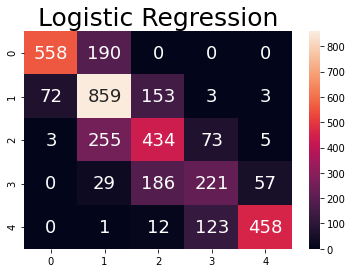

In [49]:
ax = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[0].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax)

ax.set_title('Logistic Regression', fontsize=25)
plt.savefig("./figures/confusion_matrix_LR.png",dpi=300)
plt.show()


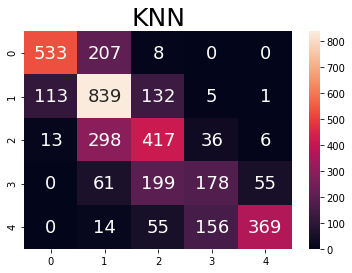

In [50]:
ax1 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[1].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax1)

ax1.set_title('KNN', fontsize=25)
plt.savefig("./figures/confusion_matrix_KNN.png",dpi=300)
plt.show()

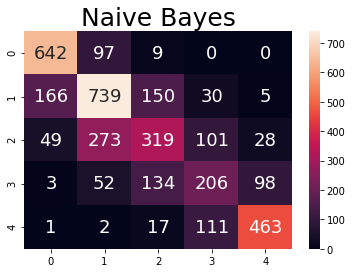

In [51]:
ax2 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[2].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax2)

ax2.set_title('Naive Bayes', fontsize=25)
plt.savefig("./figures/confusion_matrix_NB.png",dpi=300)
plt.show()

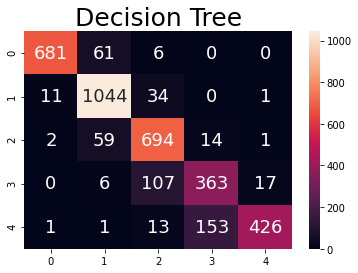

In [52]:
ax3 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[3].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax3)

ax3.set_title('Decision Tree', fontsize=25)
plt.savefig("./figures/confusion_matrix_DT.png",dpi=300)
plt.show()

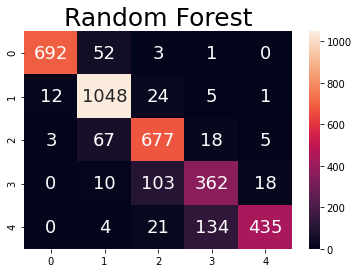

In [53]:
ax4 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[4].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax4)

ax4.set_title('Random Forest', fontsize=25)
plt.savefig("./figures/confusion_matrix_RF.png",dpi=300)
plt.show()